In [1]:
from inversion.GAN import *
from inversion.utils import *
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm


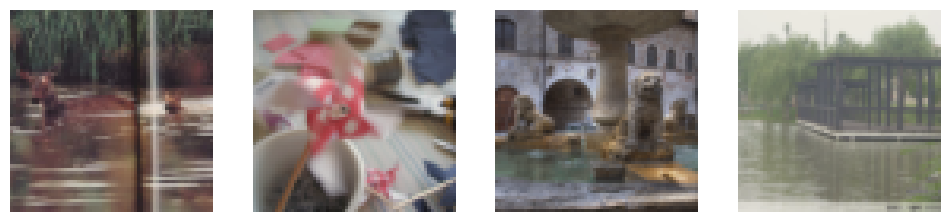

In [2]:
train_loader, test_loader = get_imagenet_loader(batch_size=256, resolution=64)
plot(denormalize(next(iter(train_loader))[0][:4]))

In [3]:
# Instantiate the generator and discriminator
base_features = 512
input_size = 128
generator = DCGenerator(input_size=input_size, base_features=base_features).to('cuda')
discriminator = init_torch_resnet()
#discriminator.requires_grad_(False)
discriminator.fc = nn.Linear(2048, 1)
discriminator = discriminator.to('cuda')

# Define the optimizer and loss function
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()
criterionD = nn.MSELoss()

generator_id = "small_gan_rn_Gen_64_512_128"
discriminator_id = "small_gan_rn_Dis"
get_latest_checkpoint(generator, model_id=generator_id)
get_latest_checkpoint(discriminator, model_id=discriminator_id)

fake_history = None

run = init_wandb_run(
    project="inversion-gan",
    run_name=f"{generator_id}_{discriminator_id}",
    config={
        "base_features": base_features,
        "gan_latent_size": input_size,
        "batch_size": 256,
        "resolution": 64,
        "generator_id": generator_id,
        "discriminator_id": discriminator_id,
        "learning_rate": 0.0002,
        "betas": (0.5, 0.999)
    },
    tags=["DCGAN", "64x64", "gen1"]
)

run_dir = f"./out/gan/{run.id}"
os.makedirs(run_dir, exist_ok=True)

# Training loop
num_epochs = 100
for epoch in range(0, num_epochs):
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for i, (images, _) in enumerate(train_loader):
            start_time = time.time()
            # Move images to CUDA
            images = images.to('cuda')

            # Create labels
            valid = torch.full((images.size(0), 1), 0.9, device='cuda', dtype=torch.float32).view(-1, 1, 1, 1)
            fake = torch.zeros(images.size(0), 1, device='cuda', dtype=torch.float32).view(-1, 1, 1, 1)

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Generate a batch of images
            z = torch.randn(images.size(0), generator.nz, device='cuda')
            gen_images = generator(z)
            if fake_history is None:
                fake_history = gen_images.detach().clone()
            else: 
                indices = torch.randint(low=0, high=gen_images.size(0), size=(1,))
                fake_history[indices] = gen_images[indices].detach().clone()
            # Calculate the percentage of correctly detected fake images
            with torch.no_grad():
                # take sigmoid of discriminator output
                prediction = torch.sigmoid(discriminator(gen_images.detach())-0.5).round()
                detected_fakes = (prediction == 0).sum().item()
                total_fake = fake.numel()
                d_detection_accuracy = detected_fakes / total_fake
            optimizer_D.zero_grad()
            # Real images
            d_loss_on_real = criterionD(torch.sigmoid(discriminator(images)-0.5), valid)
            # Fake images
            d_values_on_generated = discriminator(gen_images.detach())
            d_loss_on_generated = criterionD(d_values_on_generated, fake)
            d_values_on_history = discriminator(fake_history)
            d_loss_on_history = criterionD(d_values_on_history, fake)

            # Total loss
            d_loss = (d_loss_on_real/2 + d_loss_on_generated/2 + d_loss_on_history/2)

            d_loss.backward()
            optimizer_D.step()

            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()

            # Loss measures generator's ability to fool the discriminator
            g_loss = criterion(torch.sigmoid(discriminator(gen_images).view(-1,1,1,1)-0.5), valid/0.9)
            # calculate pixel wise variance of generated images variance.shape == (3, 64, 64)
            variance = torch.var(gen_images, dim=(0), keepdim=True).mean()
            variance_loss = (variance - 1)**2
            g_loss += variance_loss * 0.1
            
            g_loss.backward()
            optimizer_G.step()

            run.log({
                "time_per_step": time.time() - start_time if i > 0 else 0,
                "d_loss": d_loss.item(),
                "g_loss": g_loss.item(),
                "variance_loss": variance_loss.item(),
                "variance": variance.item(),
                "d_detection_accuracy": d_detection_accuracy,
                "d_values_on_generated_avg": d_values_on_generated.mean().item(),
                "d_values_on_history_avg": d_values_on_history.mean().item()
            }, step=epoch * len(train_loader) + i)

            if i % 50 == 0:
                print(f"[Epoch {epoch:4d}/{num_epochs:2d}]\n" +
                    f" [Batch {i:5d}/{len(train_loader):5d}\n" + 
                    f" [D loss: {d_loss.item()} = {d_loss_on_real.item()} + {d_loss_on_generated.item()}]\n" + 
                    f" [G loss: {g_loss.item()}]\n" + 
                    f" [Fake accuracy: {d_detection_accuracy:.2f}]")
                image_path_generated = f"{run_dir}/generated_{i:04d}.png"
                image_path_history = f"{run_dir}/history_{i:04d}.png"
                plot(denormalize(fake_history[:100]),
                     texts=[f"{d_values_on_history[i].item():.2f}" for i in range(100)],
                     show=False,
                     save_path=image_path_history)
                plot(denormalize(gen_images[:100]),
                     texts=[f"{d_values_on_generated[i].item():.2f}" for i in range(100)],
                     show=False,
                     save_path=image_path_generated)
                run.log({
                    "generated_images": wandb.Image(image_path_generated),
                    "history_images": wandb.Image(image_path_history)
                }, step=epoch * len(train_loader) + i)
                plt.show()
            pbar.update(1)

                
            if i % 200 == 0:
                checkpoint_suffix = f"epoch_{epoch:02d}"
                save_model(generator, generator_id, checkpoint_suffix=checkpoint_suffix)
                save_model(discriminator, discriminator_id, checkpoint_suffix=checkpoint_suffix)

run.finish()

model small_gan_rn_Gen_64_512_128 not found
model small_gan_rn_Dis not found


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: christopher-rossbach (team-cr). Use `wandb login --relogin` to force relogin


Epoch 1/100:   0%|          | 0/5005 [00:00<?, ?batch/s]

/home/woody/iwi1/iwi1106h/software/private/conda/envs/bube/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([256, 1, 1, 1])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch    0/100]
 [Batch     0/ 5005
 [D loss: 0.406943142414093 = 0.37272709608078003 + 0.220579594373703]
 [G loss: 0.020287493243813515]
 [Fake accuracy: 1.00]
Saved model to ./checkpoints/small_gan_rn_Gen_64_512_128/2025-07-12T21:45:49_epoch_00.pth
Saved model to ./checkpoints/small_gan_rn_Dis/2025-07-12T21:45:51_epoch_00.pth
[Epoch    0/100]
 [Batch    50/ 5005
 [D loss: 0.0009262962266802788 = 0.00019544720998965204 + 0.000514294661115855]
 [G loss: 1.063065528869629]
 [Fake accuracy: 1.00]
[Epoch    0/100]
 [Batch   100/ 5005
 [D loss: 0.002528734738007188 = 0.004702311009168625 + 0.000196147826500237]
 [G loss: 0.9851241111755371]
 [Fake accuracy: 1.00]
[Epoch    0/100]
 [Batch   150/ 5005
 [D loss: 0.0004063345259055495 = 4.3560678022913635e-05 + 0.00019077448814641684]
 [G loss: 0.9664148688316345]
 [Fake accuracy: 1.00]
[Epoch    0/100]
 [Batch   200/ 5005
 [D loss: 0.00045882153790444136 = 2.3045704438118264e-05 + 2.0865471014985815e-05]
 [G loss: 0.9601391553878784]
 [Fake

KeyboardInterrupt: 